PREPERATION

In [1]:
pip install requests beautifulsoup4

In [2]:
pip install requests beautifulsoup4 nltk

In [3]:
!pip install firebase

In [4]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.4 MB/s eta 0:00:00


In [5]:
import requests
from bs4 import BeautifulSoup
import re
import json
from firebase import firebase
from nltk.stem import PorterStemmer
from urllib.parse import urljoin
import random

FBconn = firebase.FirebaseApplication('https://hw2cloud-unicorn-default-rtdb.firebaseio.com/',None) #connection to the database- for the 4th layer, the data source layer

***2nd layer- business logic layer***

util classes:

In [6]:
#help classes to keep the url's organized and sorted after crawling
class Node:
    def __init__(self, DocID,docTitle):
        self.docTitle=docTitle
        self.DocIDs = DocID
        self.amountInPage=0
        self.docNum=0
        self.next = None

class LinkedList:
    def __init__(self):
        self.head=None
        self.counter=0
        self.frequencyInAllPages=0

    def add(self, DocID,amount,docTitle):
        newNode=Node(DocID,docTitle)
        newNode.amountInPage=amount
        newNode.docNum=self.counter
        newNode.next=self.head
        self.head=newNode
        self.frequencyInAllPages+=amount
        self.counter+=1

    def sort_by_amount(self):
        if self.head is None:
            return  # The list is empty, no need to sort

        # Perform bubble sort on the linked list
        swapped = True
        while swapped:
            swapped = False
            current = self.head
            while current and current.next:
                # Compare the current node with the next node
                if current.amountInPage < current.next.amountInPage:
                    # Swap the nodes' data
                    current.DocIDs, current.next.DocIDs = current.next.DocIDs, current.DocIDs
                    current.amountInPage, current.next.amountInPage = current.next.amountInPage, current.amountInPage
                    current.docNum, current.next.docNum = current.next.docNum, current.docNum
                    swapped = True  # Mark that a swap has occurred
                current = current.next

    def __str__(self):
      node=self.head
      str=""
      while node:
        str=str+f"docTitle: {node.docTitle},DocID: {node.DocIDs}, Amount: {node.amountInPage} ,"
        node=node.next
      return str

    def __repr__(self):
      return str(self)


main methods for the search part in the code:

In [7]:
#global data related to the code to save data
visited_urls = set()  # To avoid duplicate visits
base_url = "https://www.salesforce.com/eu/?ir=1" #main website of salesforce- where we start the crawling
index = {} #that will be a dictionary of words that are in the text
indexForRandom={}
resFromDB2ndLayer={}
firstPageFlag=0 #flag to check if there's an error entering the first page


In [8]:
def fetch_page(url):
    response = requests.get(url) #requests- a function that gets whats in the url
    if response.status_code == 200: #200- success
        soup = BeautifulSoup(response.text, 'html.parser') #BeautifulSoup - function, we tell it to take the text from response (the website it eftched infro from). we parse it
        return soup
    else:
        return None

def index_words(soup, url):
    global index
    words = re.findall(r'\w+', soup.get_text())  # Extract all words from the text
    word_counts = {}  # Dictionary to keep the count of words in the current page

    for term in words:
        term = term.lower()  # Convert to lowercase for case insensitivity
        if term in word_counts:
            word_counts[term] += 1
        else:
            word_counts[term] = 1

    #fetch weebsite's title
    if soup.title:
      title = soup.title.string
    else:
      title = "No title"

    # Update the global index with the word counts from the current page
    for term, count in word_counts.items():
        if term not in index:
            newList = LinkedList()
            newList.add(url, count,title)
            index[term] = newList
        else:
            node = index[term].head
            while node:
                if node.DocIDs == url:
                    node.amountInPage = count  # Update amountInPage with wordCounts
                    break
                node = node.next
            if node is None:
                index[term].add(url, count,title)

    return index


def remove_stop_words(index):
    stop_words = {'a', 'an', 'the', 'and', 'or', 'in', 'on', 'at', 'to','with','s','for','from','or','and','when','why','who','where','how','you','is','are','would', 'should', 'could', 'might', 'must','here', 'there','all', 'any','few','just','1','2','3','4','5','6','7','8','9'} #we want to remove stop words so we set what are our stop words ahead. this is an example. we can for example check the index count of all the words and decide to remove the 10 most common words(we print them to ourselves, check and according to the result add them to the list)
    for stop_word in stop_words:
        if stop_word in index: #we remove the stop words from the dictionary
            del index[stop_word]
    return index


def apply_stemming(index):
    stemmer = PorterStemmer()
    stemmed_index = {}

    for word, posting_list in index.items():
        stemmed_word = stemmer.stem(word)
        current = posting_list.head
        while current:
            if stemmed_word not in stemmed_index:
                stemmed_index[stemmed_word] = LinkedList()

            # Check if URL already exists in stemmed index
            existing = stemmed_index[stemmed_word].head
            url_exists = False
            while existing:
                if existing.DocIDs == current.DocIDs:
                    existing.amountInPage += current.amountInPage
                    url_exists = True
                    break
                existing = existing.next

            if not url_exists:
                stemmed_index[stemmed_word].add(
                    current.DocIDs, current.amountInPage,current.docTitle
                )

            current = current.next
    return stemmed_index



def search(query, index): #user's query and the stemmed index
   stemmer = PorterStemmer()
   query_words = re.findall(r'\w+', query.lower()) #we dont want it case sensitive and we want the things that might count as special chars to be treated as regular chars
   results = {}
   for word in query_words: #going through every word in the updated query
        word = stemmer.stem(word) #we stem the words in the query - IF WE STEM THE FETCHED DATA WE MUST STEM THE QUERY OTHERWISE WE WONT HAVE ANY RESULTS!!!!
        if word in index: #we check how many times the words in the query are in the index
            results[word] = index[word]
   return results


def search_engine(query):
    global resFromDB2ndLayer
    lowQuery={}
    results = search(query,resFromDB2ndLayer)
    query = query.split(" ") #change from string to dictionary
    query = {word: 1 for word in query}
    query=remove_stop_words(query)
    for word in query:
      lowQuery[word.lower()]=query[word]
    writeQueryWords('/searchesDB/',lowQuery)
    return results


def startEngine(url):
    global index
    global indexForRandom
    global resFromDB2ndLayer
    global newPath
    soup=crawl(url)
    if firstPageFlag==0:
      return None
    index = remove_stop_words(index)
    indexForRandom=index #to keep all the words without stemming
    index = apply_stemming(index)
    partPath=writeWordsAfterCrawl(index) #a call to the 3rd layer method- the method that writes to the db
    newPath='/wordsDB/'+partPath['name']+'/'
    resFromDB2ndLayer=fetchWordsFromDB(newPath) #for faster use instead of getting data from the db everytime




def extract_links(html):
    """Extract all links from a page."""
    #soup = BeautifulSoup(html, "html.parser")
    links = []
    for a_tag in html.find_all("a", href=True):
        href = urljoin("https://www.salesforce.com/eu", a_tag["href"])  # Convert relative URLs to absolute
        if "https://www.salesforce.com/eu" in href:  # Keep links within the domain
            links.append(href)
    return links



def crawl(url):
    global firstPageFlag
    global index
    if url in visited_urls:  # Skip already visited URLs
        return 1
    if firstPageFlag==150: #############page visits limit
        return 1
    visited_urls.add(url)

    html = fetch_page(url)
    if html:
        firstPageFlag+=1
        # Extract and process words
        index=index_words(html,url)

        # Find new links and crawl them
        links = extract_links(html)
        for link in links:
          crawl(link)

methods for the statistics page:

In [9]:
def fiveMostSearchedWords(dbName):
  words=fetchQueryWordsFromDB(dbName)
  if words==None:
    return None
  # Sort dictionary by values in descending order
  sorted_dict = dict(sorted(words.items(), key=lambda item: item[1], reverse=True))
  res={}
  i=0
  for key in sorted_dict:
    if i==5:
      break
    res[key]=sorted_dict[key]
    i+=1
  return res


def fiveRandomWordsFromWebsite():
  global resFromDB2ndLayer
  global indexForRandom
  random_words={}
  for i in range(5):
    word=random.choice(list(indexForRandom.keys()))
    random_words[word] = indexForRandom[word].frequencyInAllPages
  return random_words

methods for manager page:

In [10]:
def deleteWord(word):
  global resFromDB2ndLayer
  global indexForRandom
  global newPath
  stemmer = PorterStemmer()
  if word in indexForRandom:
    del indexForRandom[word]
  stemmed_word = stemmer.stem(word)
  res=deleteFromIndex(newPath,stemmed_word)
  if res:
    del resFromDB2ndLayer[stemmed_word]
    return True
  else:
    return False

def sendDataToManager():
  global indexForRandom #index without stemming
  return indexForRandom



***3rd layer- data access***

In [11]:
#main methods for the code - methods related to database access
resFromDB={} #index of words after fetching from db -GLOBAL

def writeWordsAfterCrawl(index): #writing the indexed words into the firebase db
        batch_data = []
        for word, posting_list in index.items():
            # Convert LinkedList to serializable format
            docs_list = []
            current = posting_list.head
            while current:
                docs_list.append({
                    'title': current.docTitle,
                    'url': current.DocIDs,
                    'count': current.amountInPage
                })
                current = current.next

            # Create the object to write
            obj = {
                'term': word,
                'frequency': posting_list.frequencyInAllPages,
                'documents': docs_list
            }
            batch_data.append(obj)

        # Attempt to write all data at once
        if batch_data:
            result = FBconn.post('/wordsDB/', batch_data)
            if not result:
                print("Failed to batch write.")
                result = False
        return result



#a method to fetch the words from the db after the crawling- faster access than accessing the db every time we search a query
def fetchWordsFromDB(dbName):
    global resFromDB
    res = FBconn.get(dbName, None)
    if res:
        data_dict = {}
        for item in res:
          if item!=None:
          #for item in res[key]:
            term = item['term']
            frequency = item['frequency']
            linked_list = LinkedList()
            linked_list.frequencyInAllPages = frequency
            for doc in item['documents']:
                node = Node(doc['url'],doc['title'])
                node.amountInPage = doc['count']
                if linked_list.head is None:
                    linked_list.head = node
                else:
                    current = linked_list.head
                    while current.next:
                        current = current.next
                    current.next = node
                linked_list.counter += 1
            data_dict[term] = linked_list
        resFromDB=data_dict
    else:
        print("Failed to fetch data from database.")
        return None
    return resFromDB



def deleteFromIndex(dbName, word):
    try:
        # Get all the data
        current_value = FBconn.get(dbName, '')
        if not current_value:
            print(f"No data found in database {dbName}")
            return False

        # Find the item and create new data list
        new_data = []
        delete_index = None
        for item in current_value:
          if item!=None:
            if item.get('term') == word:
                delete_index = str(current_value.index(item))
            else:
                new_data.append(item)

        # Only delete the specific index
        FBconn.delete(dbName, delete_index)
        return True

    except Exception as e:
        print(f"Error deleting word: {str(e)}")
        return False


def writeQueryWords(dbName, query):
    for word in query:
        # Get the current value of the word from the database
        current_value = FBconn.get(dbName, word)

        # If the word doesn't exist, initialize its value to 1
        if current_value is None:
            FBconn.put(dbName, word, 1)
        else:
            # Increment the current value by 1
            FBconn.put(dbName, word, current_value + 1)



def fetchQueryWordsFromDB(dbName):
    res = FBconn.get(dbName, None)
    if res:
        return res
    else:
        print("Failed to fetch data from database.")
        return None





**main ** - preperation methods calls- to prepare our engine before getting to the UI

In [12]:
startEngine(base_url) #a method to start the engine- crawls on the salesforce website, fethces the words and sends to the 3rd layer to write them into the db
#fetchWordsFromDB('/wordsDB/') #fetching the words from the db for faster access when sending a query

***1st layer- UI layer***

In [13]:
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output,FileLink
import matplotlib.pyplot as plt
import csv
from google.colab import files
from datetime import datetime
import os



HTML(value='\n<style>\n    body {\n        background-color: pink;\n        color: #333;\n    }\n    .widget-l…

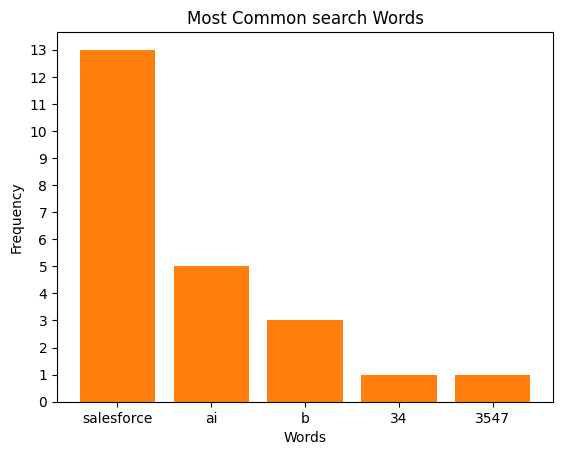

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# Create navigation buttons with pink style
def create_button(description, color, callback):
    button = widgets.Button(
        description=description,
        layout=widgets.Layout(
            width="120px",
            height="40px",
            background_color="#FF69B4",
            color="white"
        ),
        style=widgets.ButtonStyle(
            button_color="#FF69B4",
        )
    )
    button.on_click(callback)
    return button

def generate_search_report():

    # Create reports directory if it doesn't exist
    os.makedirs('reports', exist_ok=True)

    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Generate the graph
    if not showMostCommonSearches():
        return "No search data available for the report."

    # Customize the graph
    plt.title('Most Common Search Words Report')
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    # Save the figure
    filename = f'search_report_{current_time}.png'
    plt.savefig(filename, bbox_inches='tight', dpi=300, facecolor='#FFF0F5')
    plt.close()  # Close the figure to free memory

    # Download the file using Colab's files.download()
    files.download(filename)
    return None

def on_report_click(_):
    """Handle report button click"""
    # Clear any existing message
    message_label.value = ""  # Use the message label to show the result

    result = generate_search_report()

    if isinstance(result, str):  # If result is an error message
        message_label.value = f"❌ {result}"  # Show error message
        message_label.style = {'color': 'red'}
    else:
        message_label.value = "✅ Report generated and downloaded successfully!"  # Show success message
        message_label.style = {'color': 'green'}


# Global popup output
popup_output = widgets.Output()

def show_manager_popup(_):
    # Clear any existing popup content
    popup_output.clear_output()

    # Create password input field
    password_input = widgets.Password(
        description="Password:",
        placeholder="Enter 1234",
        layout=widgets.Layout(width="250px")
    )

    # Create a submit button with matching pink style
    submit_button = widgets.Button(
        description="Submit",
        layout=widgets.Layout(
            width="100px",
            height="40px",
            margin="20px 10px",
            background_color="#FF69B4",
            color="white"
        ),
        style=widgets.ButtonStyle(
            button_color="#FF69B4",
        )
    )

    # Create a message label for feedback
    feedback_label = widgets.HTML()

    # Handle the submit button click
    def submit_password(_):
        if password_input.value == "1234":
            navigate_to_manager_page(_)
        else:
            feedback_label.value = "<p style='color: red;'>Incorrect password. Please try again.</p>"
            password_input.value = ""  # Clear the password field

    submit_button.on_click(submit_password)

    # Create a close button with matching pink style
    close_button = widgets.Button(
        description="Close",
        layout=widgets.Layout(
            width="100px",
            height="40px",
            margin="20px 10px",
            background_color="#FF69B4",
            color="white"
        ),
        style=widgets.ButtonStyle(
            button_color="#FF69B4",
        )
    )

    def close_popup(_):
        popup_output.clear_output()

    close_button.on_click(close_popup)

    # Arrange components in a vertical layout with pink theme
    popup_layout = widgets.VBox([
        widgets.HTML("<h2 style='color: #333; text-align: center;'>Manager Sign-in</h2>"),
        widgets.HTML("<p style='color: #333; text-align: center;'>Please enter the password to access the manager page.</p>"),
        password_input,
        widgets.HBox([submit_button, close_button], layout=widgets.Layout(
            justify_content='center',
            align_items='center'
        )),
        feedback_label
    ], layout=widgets.Layout(
        width="400px",
        padding="20px",
        border="2px solid #FF69B4",
        background_color="#FFF0F5",
        position="absolute",
        top="50%",
        left="50%",
        transform="translate(-50%, -50%)",
        z_index="999",
        align_items="center"
    ))

    # Display the popup
    with popup_output:
        display(popup_layout)

def navigate_to_manager_page(_):
    # Clear the main content
    clear_output()
    data = sendDataToManager()

    # Create title
    title = widgets.HTML(
        value="<h1 style='text-align: center; color: #333;'>Manager Page</h1>"
    )

    # Create Combobox (Dropdown with search)
    dropdown = widgets.Combobox(
        options=list(data.keys()),
        value=list(data.keys())[0] if data else '',
        placeholder='Type to search...',
        description='Select:',
        ensure_option=False,  # Allows free text input for searching
        layout=widgets.Layout(width='250px')
    )

    # Label for success or error message
    global message_label
    message_label = widgets.Label(
        value="",
        layout=widgets.Layout(margin="10px 0 0 0")
    )

    # Create delete button
    delete_button = widgets.Button(
        description="Delete",
        layout=widgets.Layout(
            width="100px",
            height="30px",
            background_color="#FF4444",
            margin="0px 10px"
        ),
        style=widgets.ButtonStyle(
            button_color="#FF4444",
        )
    )

    # Delete button callback
    def on_delete_click(_):
        success = deleteWord(dropdown.value)

        if success:
            message_label.value = "Deleted successfully!"
            # Update the dropdown list after deletion
            data = sendDataToManager()  # Re-fetch the data to update the dropdown
            dropdown.options = list(data.keys())  # Update the dropdown options
            dropdown.value = dropdown.options[0] if dropdown.options else None  # Reset the value
        else:
            message_label.value = "Unable to delete."

    delete_button.on_click(on_delete_click)

    # Create back button
    def go_back(_):
        clear_output()
        display(custom_style)
        display(content_layout)

    back_button = widgets.Button(
        description="← Back",
        layout=widgets.Layout(
            width="100px",
            height="40px",
            background_color="#FF69B4",
            color="white",
            margin="10px 10px 10px 10px",  # Add margin for spacing
        ),
        style=widgets.ButtonStyle(
            button_color="#FF69B4",
        )
    )
    back_button.on_click(go_back)

    # Create report button
    report_button = widgets.Button(
        description="Generate Most Searched Words Report",
        layout=widgets.Layout(
            width="300px",
            height="40px",
            background_color="#4CAF50",
            margin="20px auto",
            display="flex",
            justify_content="center"
        ),
        style=widgets.ButtonStyle(
            button_color="#4CAF50",
        )
    )

    # Add the report button callback
    report_button.on_click(on_report_click)

    # Create horizontal box for dropdown and delete button
    selection_box = widgets.HBox([dropdown, delete_button],
        layout=widgets.Layout(
            display='flex',
            flex_flow='row',
            align_items='center',
            width='100%',
            justify_content='center'
        )
    )

    # Create horizontal box for back button
    back_button_box = widgets.HBox([back_button], layout=widgets.Layout(
        display='flex',
        justify_content='flex-start',  # Align back button to the left
        width='100%'  # Make the HBox span the entire width to allow left alignment
    ))

    # Check if showMostCommonSearches() returns None
    most_common_searches_output = widgets.Output(
        layout=widgets.Layout(
            width='60%',
            margin='0 auto'
        )
    )

    with most_common_searches_output:
        if not showMostCommonSearches():  # If showMostCommonSearches() returns None or no searches
            print("No searches were made.")
        else:
            showMostCommonSearches()  # Display the graph if it exists

    # Create vertical box for all elements
    page_layout = widgets.VBox([
        back_button_box,  # Add the back button in its HBox
        title,
        widgets.HTML(value="<br>"),
        selection_box,
        report_button,
        message_label,  # Place message label here
        widgets.HTML(value="<br><br>"),
        widgets.HTML("<h3 style='text-align: center; color: #333;'>5 Most Common Searches</h3>"),
        most_common_searches_output  # Display the searches graph or message here
    ], layout=widgets.Layout(
        display='flex',
        flex_flow='column',
        align_items='center',  # Center other elements
        width='100%'
    ))

    display(custom_style)
    display(page_layout)














def navigate_to_statistics(_):
    # Clear the main content
    clear_output()

    # Display custom style first to ensure consistent styling
    display(custom_style)

    # Create a back button that goes back to the home page
    def go_back(_):
        clear_output()
        display(custom_style)
        display(content_layout)

    back_button = widgets.Button(
        description="← Back",
        layout=widgets.Layout(
            width="100px",
            height="40px",
            background_color="#FFB6C1",
            color="white",
            margin="10px 0"
        ),
        style=widgets.ButtonStyle(
            button_color="#FFB6C1",
        )
    )
    back_button.on_click(go_back)

    # Create a figure to hold the subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.patch.set_facecolor('#FFF0F5')

    # Add more padding around the subplots for better centering
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9)

    # Style each subplot
    for ax in axes:
        ax.set_facecolor('#FFF0F5')
        ax.spines['bottom'].set_color('#333')
        ax.spines['top'].set_color('#333')
        ax.spines['left'].set_color('#333')
        ax.spines['right'].set_color('#333')
        ax.tick_params(colors='#333')
        ax.title.set_color('#333')

    # First subplot (Most Common Searches)
    plt.sca(axes[0])
    if not showMostCommonSearches():
        axes[0].text(0.5, 0.5, "No searches were made", ha='center', va='center', fontsize=15, color='red')
    else:
        showMostCommonSearches()

    # Second subplot (Random Words)
    plt.sca(axes[1])
    showRandomWords()

    # Adjust layout
    plt.tight_layout()

    # Create a container for the back button that aligns it to the left
    back_button_container = widgets.Box(
        [back_button],
        layout=widgets.Layout(
            width='100%',
            display='flex',
            justify_content='flex-start',
            padding='0 20px'
        )
    )

    # Create an Output widget for the plots with specific width
    plot_output = widgets.Output(
        layout=widgets.Layout(
            width='60%',
            margin='0 auto'
        )
    )

    # Create a VBox layout for the statistics page
    statistics_layout = widgets.VBox([
        back_button_container,
        widgets.HTML(value="<h1 style='text-align: center; color: #333; font-size: 45px;'>Statistics</h1>"),
        widgets.HTML(value="<h2 style='text-align: center; color: #333;'>Explore the most common searches and random words</h2>"),
        widgets.HTML(value="<br>"),
        plot_output
    ], layout=widgets.Layout(
        width="100%",
        height="auto",
        margin="auto",
        padding="20px",
        align_items="center",
        background_color="#FFF0F5"
    ))

    # Display the statistics layout
    display(statistics_layout)

    # Show the plots in the configured output area
    with plot_output:
        plt.show()

def create_search_results_page(query):
    # Clear the main content
    clear_output()
    results = search_engine(query)

    #add all linked lists found to one list so we can sort it by amount in page
    all_linked_lists = LinkedList()
    for key, linked_list in results.items():
        current_node = linked_list.head
        while current_node:
            all_linked_lists.add(current_node.DocIDs, current_node.amountInPage, current_node.docTitle)
            current_node = current_node.next
    all_linked_lists.sort_by_amount()

    # Create back button
    def go_back(_):
        clear_output()
        display(custom_style)
        display(content_layout)

    back_button = widgets.Button(
        description="← Back",
        layout=widgets.Layout(
            width="100px",
            height="40px",
            background_color="#FF69B4",
            color="white",
            margin="10px"
        ),
        style=widgets.ButtonStyle(
            button_color="#FF69B4",
        )
    )
    back_button.on_click(go_back)

    # Create search results layout
    results_header = widgets.HTML(
        value=f"<h1 style='text-align: center; color: #333;'>Search Results for: {query}</h1>"
    )

    # Start building the results content
    results_content = "<div style='padding: 20px; color: #333;'>"
    results_content += f"<h2>Results found for: \"{query}\"</h2>"

    # Check if results is empty
    if not results:
        results_content += "<p>No results found.</p>"
    else:
        idx = 1
        current_node = all_linked_lists.head
        while current_node:
            url = current_node.DocIDs
            amount = current_node.amountInPage
            title = current_node.docTitle
            results_content += f"""
            <div style='margin: 20px 0; padding: 10px; border-bottom: 1px solid #ddd;'>
                <h3>Result {idx}</h3>
                <p style="font-size: 18px; color:#4B0082; font-weight: bold;">{title}</p>
                <p><a href="{url}" target="_blank">{url}</a></p>
                <p>Amount of appearances in page: {amount}</p>
            </div>
            """
            current_node = current_node.next
            idx += 1

    results_content += "</div>"
    results_widget = widgets.HTML(value=results_content)

    results_layout = widgets.VBox([
        back_button,
        results_header,
        results_widget
    ], layout=widgets.Layout(
        width="80%",
        margin="auto",
        padding="20px",
        background_color="#FFF0F5"
    ))

    display(custom_style)
    display(results_layout)

def on_search(_):
    query = search_box.value
    if query.strip():
        create_search_results_page(query)

# Create navigation buttons
manager_button = create_button("Manager Page", "info", show_manager_popup)
statistics_button = create_button("Statistics Page", "info", navigate_to_statistics)

# Create search bar with black text
search_box = widgets.Text(
    placeholder="Type your query here...",
    layout=widgets.Layout(
        width="400px",
        height="40px",
        color="black"
    ),
    style={'description_width': 'initial'}
)

# Pink search button
search_button = widgets.Button(
    description="Search",
    layout=widgets.Layout(
        width="100px",
        height="40px",
        background_color="#FFB6C1",
        color="white"
    ),
    style=widgets.ButtonStyle(
        button_color="#FFB6C1"
    )
)
search_button.on_click(on_search)

# Custom CSS
custom_style = widgets.HTML("""
<style>
    body {
        background-color: pink;
        color: #333;
    }
    .widget-label {
        color: #333 !important;
    }
    .widget-button {
        background-color: #FF69B4 !important;
        color: white !important;
        border: none !important;
    }
    .widget-button:hover {
        background-color: #FF1493 !important;
    }
    .widget-text input {
        color: black !important;
    }
    .widget-output pre {
        color: black !important;
    }
</style>
""")

# Layout configuration
top_buttons = widgets.HBox(
    [manager_button, statistics_button],
    layout=widgets.Layout(
        justify_content="flex-start",
        padding="10px",
        width="100%",
        display="flex"
    )
)

welcome_message = widgets.HTML(
    value="<h1 style='text-align: center; color: #333;font-size: 45px;'>Welcome to CloudAccess</h1>",
    layout=widgets.Layout(width="100%",display="flex",justify_content="center", align_items="center",margin="0 0 10px 0")
)

by_message = widgets.HTML(
    value="<h2 style='text-align: center; color: #333;'>By Unicorn Team🦄</h2>",
    layout=widgets.Layout(width="100%",display="flex",justify_content="center", align_items="center",margin="0 0 10px 0")
)

search_area = widgets.HBox(
    [search_box, search_button],
    layout=widgets.Layout(
        justify_content="center",
        align_items="center",
        margin="20px auto"
    )
)

gif_widget = widgets.HTML(
    value="""
    <div style="display: flex; justify-content: center; margin: 20px;">
        <img src="https://media1.giphy.com/media/CSbIZi52DvqnJPm1WA/giphy.gif?cid=6c09b952xlwat0pfrgsbc8tymfndgrg07hipvl4ycpat5v1z&ep=v1_gifs_search&rid=giphy.gif&ct=g"
             alt="Welcome GIF"
             style="width: 300px; height: 200px; border-radius: 8px;">
    </div>
    """
)

content_layout = widgets.VBox(
    [
        popup_output,  # Add popup_output at the top
        top_buttons,
        widgets.HTML(value="<br>"),
        welcome_message,
        by_message,
        search_area,
        gif_widget,
        widgets.HTML(value="<br><br>")
    ],
    layout=widgets.Layout(
        width="100%",
        height="auto",
        margin="auto",
        padding="20px",
        align_items="center"
    )
)

# Display the custom style and the page layout
display(custom_style)
display(content_layout)

most searched words statistics

In [15]:
def showMostCommonSearches():
  mostCommonWords=fiveMostSearchedWords('/searchesDB/')
  if mostCommonWords==None:
    return False
  plt.yticks(range(0, max(mostCommonWords.values()) + 1, 1))  # Set y-ticks to be integers
  plt.bar(mostCommonWords.keys(), mostCommonWords.values())
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.title('Most Common search Words')
  return True


random words statistics:

In [16]:
# Function to display actual values from random_words.values()
def func(pct, allvalues):
    absolute = int(pct / 100. * sum(allvalues))  # Get the actual value
    return f"{absolute}"  # Display the actual value (not percentage)

def showRandomWords():
    random_words = fiveRandomWordsFromWebsite()  # Get random words from the website

    # Plot the pie chart
    plt.pie(random_words.values(), labels=random_words.keys(), autopct=lambda pct: func(pct, random_words.values()))

    plt.title('Random Words from Salesforce Website')  # Title for the pie chart



